### Testing_simulator-3param-3baselines  

Objective is to test the base case of 3 antennas (3 baselines) and 1 point source  
We analyze the performance of the LMA by  comparing two sky model paramters.  
1. one closer to the true source parameter solution.  
2. one further away from the true source parameter solution.  

Plotted are:  
1. Model vs True visibilities for before and after the LMA.  
2. $\chi^2$-error plots measuring the performance of the LMA on both model parameters.  
3. Solution space plotting the objective function, $||\mathbf{R}||^2 = ||\mathbf{D}-\mathbf{M}(A,l,m)||^2$ where the global minimum is located at the true parameter values.  
4. Solution path showing the updates of the model parameter values per iteration of the LMA.
5. $uv$-tracks showing the $uv$-coverage of the observation. 
6. We also plot the $\chi^2$-error plots for different values of $A$ given $l,m$ are well-conditioned.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import ProjectPacks as pp
import ProjectFuncs as pf

%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)  #spreads out plot surface for better visualization

from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

from IPython.display import HTML
HTML('../style/code_toggle.html')

In [2]:
## Choose number of timeslots
timeslots= 300
A_mod,l_mod,m_mod,ut,vt,arrayHxpos=pp.formatSParams('Array_Profile.txt','Field_Profile.txt',td=timeslots)

ut= ut[:3,:3]
vt= vt[:3,:3]

nbl= len(ut)*(len(ut)-1)

t = np.arange(0, 5, 5/timeslots)          #The points at which we will be taking our "measurements"
noise = 0.000*np.random.normal(size=(timeslots*nbl)) #A noise vector used to manufacture "real" measurements.

x_true = np.radians([[0.34, 0.45, 4.]])          #The true (starting) values of our parameter vector (for alg).

x_mod_near = np.radians([[0.5,0.75,5.]])   #closer
x_mod_far = np.radians([[0.5,-0.5,5.]])   #further

x_start_near= x_mod_near.copy()
x_start_far= x_mod_far.copy()

d = pf.modfunc(x_true, ut, vt) + noise #Our "observed" data, contructed from our true parameter values and the noise vector.

In [3]:
subps=["311","312","312"]
bls= ["12","13","23"]

def plotVis(m,legend_x, ut=ut,subps=["311","312","312"], bls= ["12","13","23"],t=t):
    plt.figure()
    for j in range(len(ut)):
        ax = plt.subplot(subps[j])
        ax.set_title("Real baseline {}".format(bls[j]), fontsize=18)
        ax.plot(range(timeslots),d[j*t.shape[0]:(j+1)*t.shape[0]].real*180/np.pi,'r',
                range(timeslots),m[j*t.shape[0]:(j+1)*t.shape[0]].real*180/np.pi,'b', linewidth= 2.0)
        ax.set_xlabel("Timeslot", fontsize=18)
        ax.set_ylabel("Jy", fontsize=18)
        plt.legend(legend_x, loc="upper right")
        ax.set_xlim([1,t.shape[0]])
        y_t = ax.get_yticks()
        y_t = y_t[::2]
        ax.set_yticks(y_t)

        plt.tight_layout()
        plt.show()

    plt.figure()
    for j in range(len(ut)):
        ax = plt.subplot(subps[j])
        ax.set_title("imaginary baseline {}".format(bls[j]), fontsize=18)
        ax.plot(range(timeslots),d[j*t.shape[0]:(j+1)*t.shape[0]].imag*180/np.pi,'r', 
                range(timeslots),m[j*t.shape[0]:(j+1)*t.shape[0]].imag*180/np.pi, 'b', linewidth= 2.0)
        ax.set_xlabel("Timeslot", fontsize=18)
        ax.set_ylabel("Jy", fontsize=18)
        plt.legend(legend_x, loc="upper right")
        ax.set_xlim([1,t.shape[0]])
        y_t = ax.get_yticks()
        y_t = y_t[::2]
        ax.set_yticks(y_t)

        plt.tight_layout()
        plt.show()

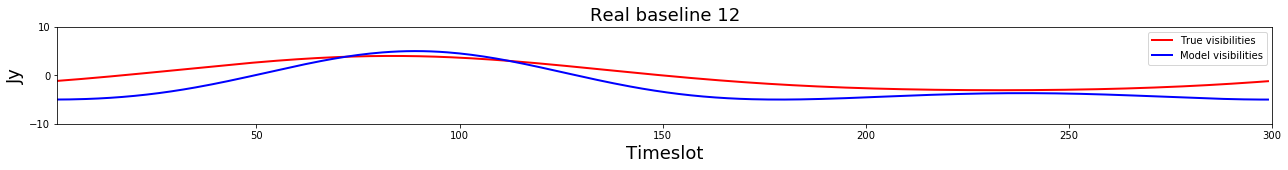

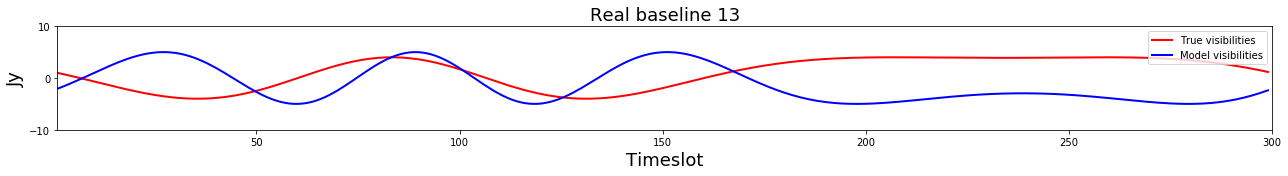

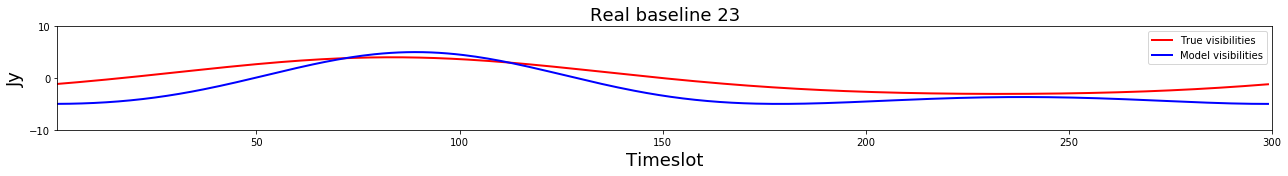

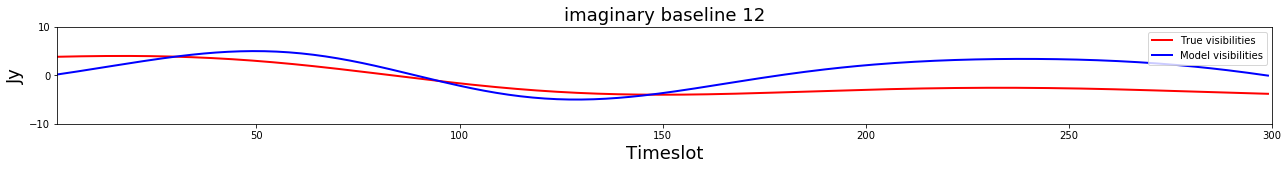

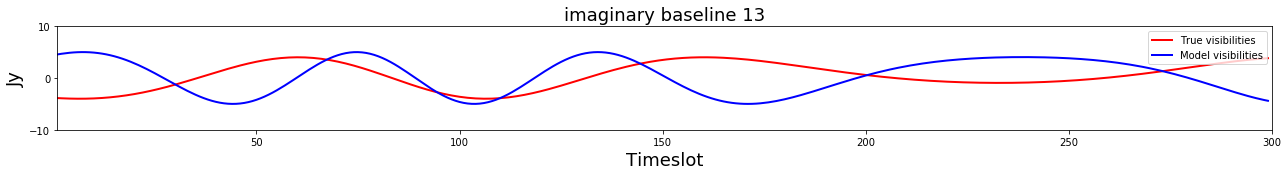

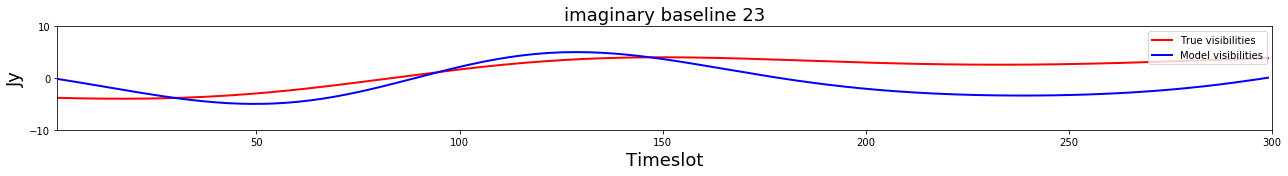

In [4]:
plotVis(m=pf.modfunc(x_mod_near, ut, vt), legend_x=["True visibilities","Model visibilities"])

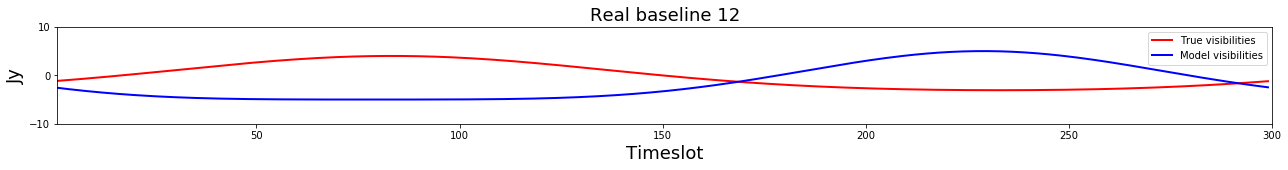

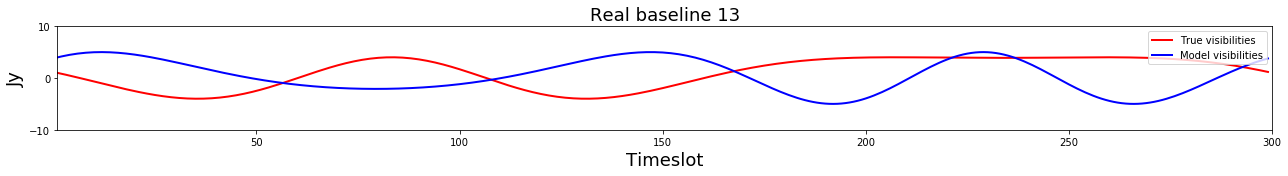

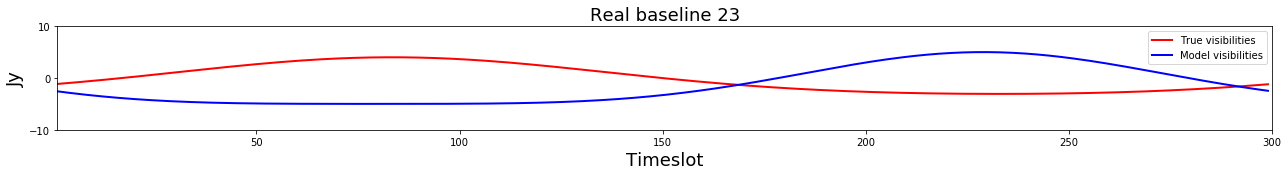

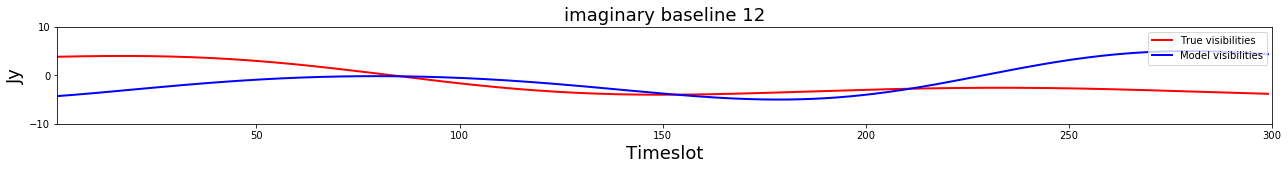

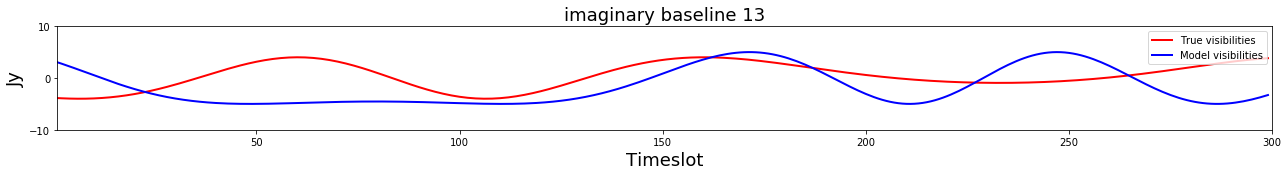

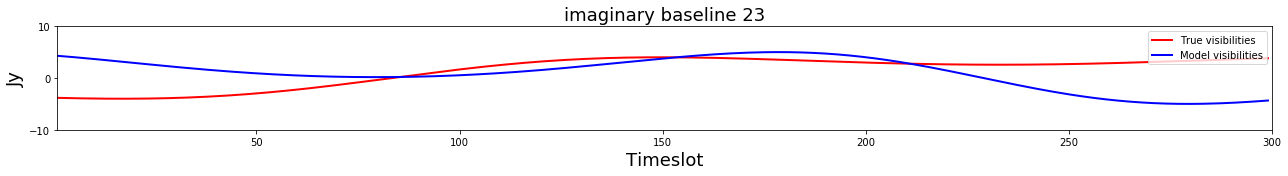

In [5]:
plotVis(m=pf.modfunc(x_mod_far, ut, vt),legend_x=["True visibilities","Model visibilities"])

In [6]:
## trying out real case first
def levenberg_marquardt(data, u_ant, v_ant, x, r_func, j_func, maxit=100, lamda=1, K=10, eps1=1e-6, eps2=1e-6):
    """
    Returns a vector containing the optimal parameter values found by the algorithm.
    
    INPUTS:
    data      Vector of measured values.
    x         Vector of parameters. (S,3)
    r_func    Function which generates the residual vector. (1,t*nb)
    j_func    Function which generates the (Conjugate of) Jacobian & the Hessian. (S*3,t*nb) & (S*3,S*3) 
    maxit     Maximum number of iterations.
    lamda     Initial value of tuning parameter.
    K         Initial value of retuning factor.
    eps1      First tolerance parameter - triggers when residual is below this number.
    eps2      Second tolerance parameter - triggers when relative changes to the parameter
              vector are below this number.
    """
    
    #Initialises some important values and stores the original lamda value.
    r = r_func(x, u_ant, v_ant, data)
    print("Shape of residual vec: ", np.shape(r))
    
    old_chi = np.linalg.norm(r)
    olamda = lamda
    it = 0

    chiplot=[]
    chiplot.append(old_chi)
    
    solpath= x
    
    while True:
        solpath= np.vstack((solpath,x))  
        #Heavy lifting portion of the algorithm. Computes the parameter update.
        #This is just the implementation of the mathmatical update rule.
        JH,JHJ = j_func(x,u_ant,v_ant)
        
        JHJdiag = np.diag(np.diag(JHJ))
        #this says there is a different D for each timeslot
        #lamda = 1 if (it%2==0) else 0
        JHJinv= np.linalg.pinv(JHJ+lamda*JHJdiag)
        JHr = JH.dot(r)
        
        delta_x = JHJinv.dot(JHr)        
        x += delta_x.real.reshape((len(x),3))
        
        #solpath= np.vstack((solpath,x))  
        
        #Convergence tests. If a solution has been found, returns the result.
        #The chi value is the norm of the residual and is used to determine
        #whether the solution is improving. If the chi value is sufficiently 
        #small, the function terminates. The second test checks to see whether
        #or not the solution is improving, and terminates if it isn't.
        
        r = r_func(x, u_ant, v_ant, data)
        new_chi = np.linalg.norm(r)
        chiplot.append(new_chi)
        
        if new_chi < eps1:
            return x,chiplot,solpath
        elif np.linalg.norm(delta_x.real) < eps2*(np.linalg.norm(x) + eps2):
            return x,chiplot,solpath
        
        #Tuning stage. If the parameter update was good, continue and restore lamda.
        #If the update was bad, scale lamda by K and revert last update.
        
        if new_chi > old_chi:
            x -= delta_x.real.reshape((len(x),3))
            lamda = lamda*K
        else:
            old_chi = new_chi
            lamda = olamda
            
        #If the number of iterations grows too large, return the last value of x.
        
        it += 1
            
        if it >= maxit:
            return x,chiplot,solpath


In [7]:
solved_x_near,cplot_near,spath_near = levenberg_marquardt(d,ut,vt,x_mod_near,pf.modfunc_res,pf.modfunc_jac)
print("model x: \n",  x_start_near) #got from up there
print("solved x: \n", solved_x_near)
print("true x: \n", x_true)

Shape of residual vec:  (1800,)
model x: 
 [[ 0.00872665  0.01308997  0.08726646]]
solved x: 
 [[ 0.00593412  0.00785398  0.06981311]]
true x: 
 [[ 0.00593412  0.00785398  0.06981317]]


In [8]:
solved_x_far,cplot_far,spath_far = levenberg_marquardt(d,ut,vt,x_mod_far,pf.modfunc_res,pf.modfunc_jac)
print("model x: \n",  x_start_far) #got from up there
print("solved x: \n", solved_x_far)
print("true x: \n", x_true)

Shape of residual vec:  (1800,)
model x: 
 [[ 0.00872665 -0.00872665  0.08726646]]
solved x: 
 [[ 0.00945432 -0.01235462  0.00314347]]
true x: 
 [[ 0.00593412  0.00785398  0.06981317]]


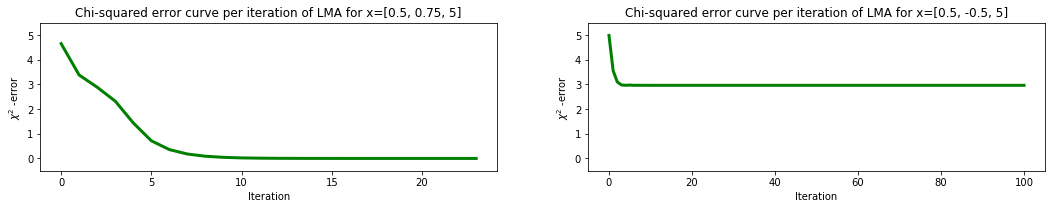

In [9]:
plt.figure()

plt.subplot(221)
plt.plot(cplot_near,'g',linewidth= 3.0)
plt.xlabel("Iteration")
plt.ylabel(r'$\chi^2$'+" -error")
plt.ylim([-0.5,5.5])
plt.title("Chi-squared error curve per iteration of LMA for x={}".format([0.5,0.75,5]))

plt.subplot(222)
plt.plot(cplot_far,'g',linewidth= 3.0)
plt.xlabel("Iteration")
plt.ylabel(r'$\chi^2$'+" -error")
plt.ylim([-0.5,5.5])
plt.title("Chi-squared error curve per iteration of LMA for x={}".format([0.5,-0.5,5]))

plt.show()

In [10]:
#still for one source
L= np.radians(np.arange(-1,1,2/timeslots))    ##Already convert it to radians up here!!! HAHA
M= np.radians(np.arange(-1,1,2/timeslots))
A= np.radians(np.arange(1,11,10/timeslots))

rr_constA= np.empty((timeslots,timeslots))
rr_constM= np.empty((timeslots,timeslots))
rr_constL= np.empty((timeslots,timeslots))

for a in range(timeslots):
    for b in range(timeslots):
        
        x_rA= np.array([[L[a],M[b],x_true[0,2]]]) ## no radians needed here!!! look up there 
        rr_constA[a,b]= np.square(np.linalg.norm(pf.modfunc_res(x_rA,ut,vt,d)))

        x_rM= np.array([[L[a],x_true[0,1],A[b]]])
        rr_constM[a,b]= np.square(np.linalg.norm(pf.modfunc_res(x_rM,ut,vt,d)))
        
        x_rL= np.array([[x_true[0,0],M[a],A[b]]])
        rr_constL[a,b]= np.square(np.linalg.norm(pf.modfunc_res(x_rL,ut,vt,d)))
        
Minimum_A= np.unravel_index(np.argmin(rr_constA),rr_constA.shape)
print("Minimum of (L,M) at: ", Minimum_A)
print(rr_constA[Minimum_A])

Minimum_M= np.unravel_index(np.argmin(rr_constM),rr_constM.shape)
print("Minimum of (L,A) at: ", Minimum_M)
print(rr_constM[Minimum_M])

Minimum_L= np.unravel_index(np.argmin(rr_constL),rr_constL.shape)
print("Minimum of (M,A) at: ",Minimum_L)
print(rr_constL[Minimum_L])

Minimum of (L,M) at:  (201, 217)
0.0030925595502
Minimum of (L,A) at:  (201, 90)
2.57958474208e-26
Minimum of (M,A) at:  (217, 90)
0.0030925595502


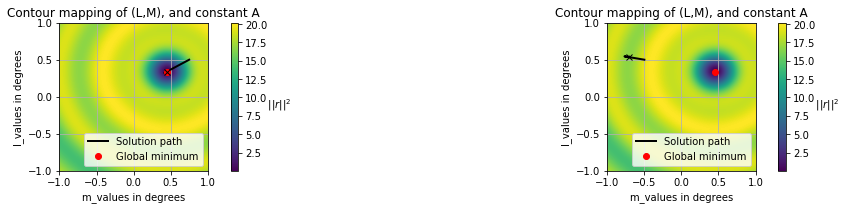

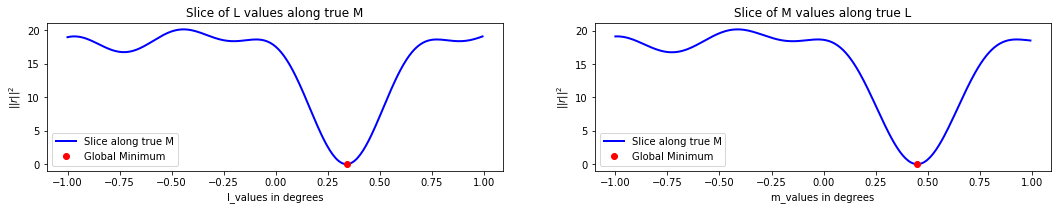

In [20]:
plt.rcParams['figure.figsize'] = (18, 6)
plt.subplot(221)
plt.imshow(np.flipud(rr_constA), extent=[-1,1,-1,1])
plt.plot(spath_near[1:,1,]*180/np.pi, spath_near[1:,0]*180/np.pi, 'k',lw=2) 
plt.plot(x_true[0,1]*180/np.pi,x_true[0,0]*180/np.pi,'ro', solved_x_near[0,1]*180/np.pi, solved_x_near[0,0]*180/np.pi, 'kx',lw=1)
plt.colorbar().set_label(r'     $||r||^2$',rotation=0)
plt.grid()
plt.xlabel("m_values in degrees")
plt.ylabel("l_values in degrees")
plt.title("Contour mapping of (L,M), and constant A")
plt.legend(["Solution path","Global minimum"],loc="lower right")

plt.subplot(222)
plt.imshow(np.flipud(rr_constA), extent=[-1,1,-1,1])
plt.plot(spath_far[1:,1,]*180/np.pi, spath_far[1:,0]*180/np.pi, 'k',lw=2) 
plt.plot(x_true[0,1]*180/np.pi,x_true[0,0]*180/np.pi,'ro', solved_x_far[0,1]*180/np.pi, solved_x_far[0,0]*180/np.pi, 'kx',lw=1)
plt.colorbar().set_label(r'     $||r||^2$',rotation=0)
plt.grid()
plt.xlabel("m_values in degrees")
plt.ylabel("l_values in degrees")
plt.title("Contour mapping of (L,M), and constant A")
plt.legend(["Solution path","Global minimum"],loc="lower right")

plt.show()

plt.subplot(221)
plt.plot(L*180/np.pi,rr_constA[:,Minimum_A[1]], 'b', x_true[0,0]*180/np.pi,[0],'ro',linewidth=2.0,)
plt.title("Slice of L values along true M")
plt.xlabel("l_values in degrees")
plt.ylabel(r"$||r||^2$")
plt.legend(["Slice along true M","Global Minimum"])
plt.subplot(222)
plt.plot(M*180/np.pi,rr_constA[Minimum_A[0],:], 'b', x_true[0,1]*180/np.pi,[0],'ro',linewidth=2.0)
plt.title("Slice of M values along true L")
plt.xlabel("m_values in degrees")
plt.ylabel(r"$||r||^2$")
plt.legend(["Slice along true M","Global Minimum"])
plt.show()

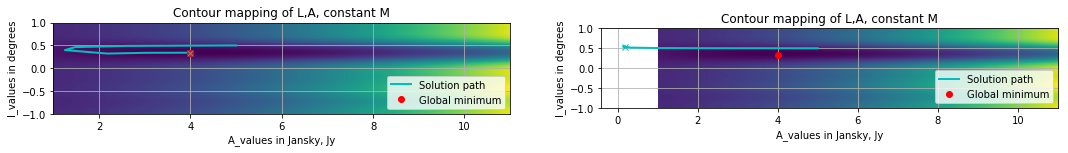

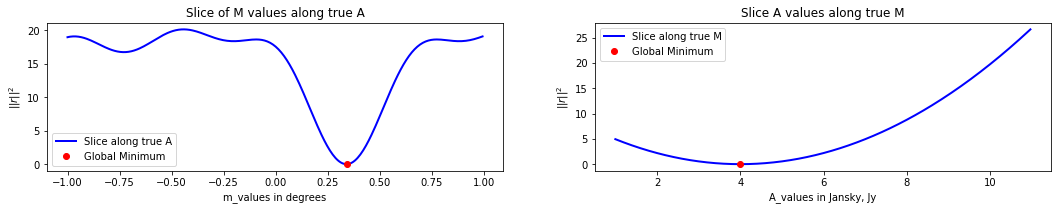

In [21]:
plt.subplot(221)
plt.imshow(np.flipud(rr_constM), extent=[1,11,-1,1])
plt.plot(spath_near[1:,2]*180/np.pi, spath_near[1:,0]*180/np.pi, 'c',lw=2)
plt.plot(x_true[0,2]*180/np.pi,x_true[0,0]*180/np.pi,'ro',spath_near[-1,2]*180/np.pi, spath_near[-1,0]*180/np.pi, 'cx',lw=1)
#plt.colorbar().set_label(r'     $||D-M||^2$',rotation= 0)
plt.grid()
plt.xlabel("A_values in Jansky, Jy")
plt.ylabel("l_values in degrees")
plt.title("Contour mapping of L,A, constant M")
plt.legend(["Solution path","Global minimum"],loc="lower right")

plt.subplot(222)
plt.imshow(np.flipud(rr_constM), extent=[1,11,-1,1])
plt.plot(spath_far[1:,2]*180/np.pi, spath_far[1:,0]*180/np.pi, 'c',lw=2)
plt.plot(x_true[0,2]*180/np.pi,x_true[0,0]*180/np.pi,'ro',spath_far[-1,2]*180/np.pi, spath_far[-1,0]*180/np.pi, 'cx',lw=1)
#plt.colorbar().set_label(r'     $||D-M||^2$',rotation= 0)
plt.grid()
plt.xlabel("A_values in Jansky, Jy")
plt.ylabel("l_values in degrees")
plt.title("Contour mapping of L,A, constant M")
plt.legend(["Solution path","Global minimum"],loc="lower right")

plt.show()

plt.subplot(221)
plt.plot(L*180/np.pi,rr_constM[:,Minimum_M[1]], 'b', x_true[0,0]*180/np.pi,[0],'ro', linewidth= 2.0)
plt.title("Slice of M values along true A")
plt.xlabel("m_values in degrees")
plt.ylabel(r"$||r||^2$")
plt.legend(["Slice along true A","Global Minimum"])
plt.subplot(222)
plt.plot(A*180/np.pi,rr_constM[Minimum_M[0],:], 'b', x_true[0,2]*180/np.pi,[0],'ro',linewidth=2.0)
plt.title("Slice A values along true M")
plt.xlabel("A_values in Jansky, Jy")
plt.ylabel(r"$||r||^2$")
plt.legend(["Slice along true M","Global Minimum"])
plt.show()


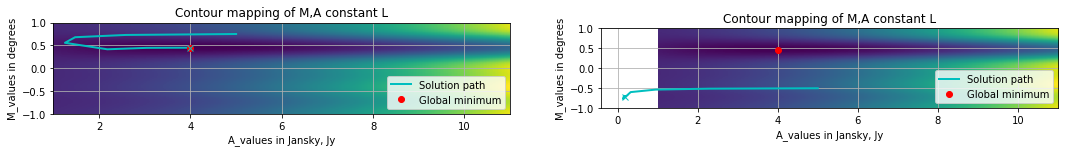

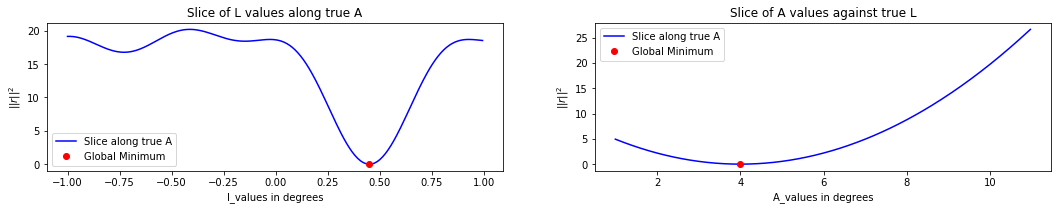

In [22]:
plt.subplot(221)
plt.imshow(np.flipud(rr_constL), extent=[1,11,-1,1])
plt.plot(spath_near[1:,2]*180/np.pi, spath_near[1:,1]*180/np.pi, 'c',lw=2)
plt.plot(x_true[0,2]*180/np.pi,x_true[0,1]*180/np.pi,'ro',spath_near[-1,2,]*180/np.pi, spath_near[-1,1]*180/np.pi, 'cx',lw=1)
#plt.colorbar().set_label(r'     $||D-M||^2$',rotation= 0)
plt.grid()
plt.xlabel("A_values in Jansky, Jy")
plt.ylabel("M_values in degrees")
plt.title("Contour mapping of M,A constant L")
plt.legend(["Solution path","Global minimum"],loc="lower right")

plt.subplot(222)
plt.imshow(np.flipud(rr_constL), extent=[1,11,-1,1])
plt.plot(spath_far[1:,2]*180/np.pi, spath_far[1:,1]*180/np.pi, 'c',lw=2)
plt.plot(x_true[0,2]*180/np.pi,x_true[0,1]*180/np.pi,'ro',spath_far[-1,2,]*180/np.pi, spath_far[-1,1]*180/np.pi, 'cx',lw=1)
#plt.colorbar().set_label(r'     $||D-M||^2$',rotation= 0)
plt.grid()
plt.xlabel("A_values in Jansky, Jy")
plt.ylabel("M_values in degrees")
plt.title("Contour mapping of M,A constant L")
plt.legend(["Solution path","Global minimum"],loc="lower right")

plt.show()

plt.subplot(221)
plt.plot(M*180/np.pi,rr_constL[:,Minimum_L[1]], 'b', x_true[0,1]*180/np.pi,[0],'ro')
plt.title("Slice of L values along true A")
plt.xlabel("l_values in degrees")
plt.ylabel(r"$||r||^2$")
plt.legend(["Slice along true A","Global Minimum"])
plt.subplot(222)
plt.plot(A*180/np.pi,rr_constL[Minimum_L[0],:], 'b', x_true[0,2]*180/np.pi,[0],'ro')
plt.title("Slice of A values against true L")
plt.xlabel("A_values in degrees")
plt.ylabel(r"$||r||^2$")
plt.legend(["Slice along true A","Global Minimum"])
plt.show()


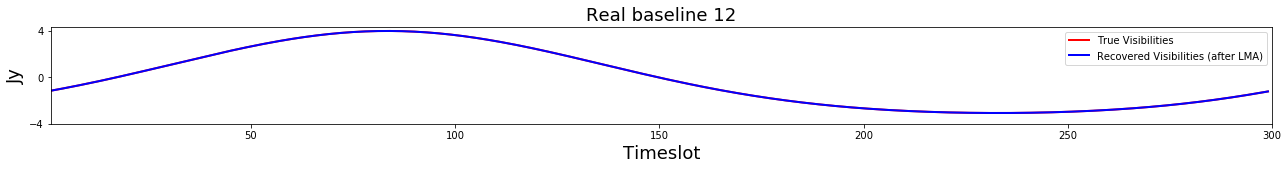

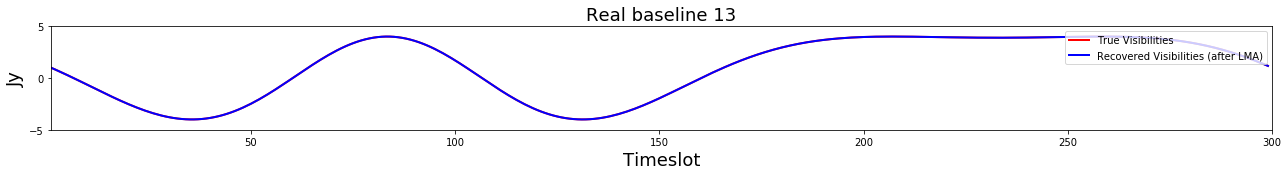

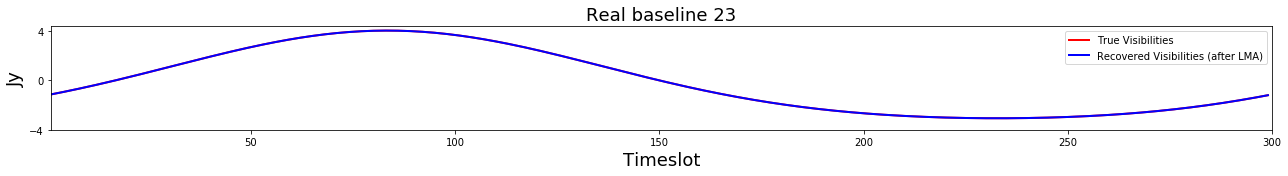

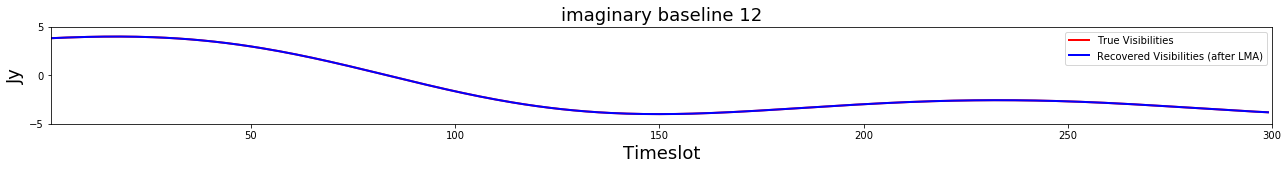

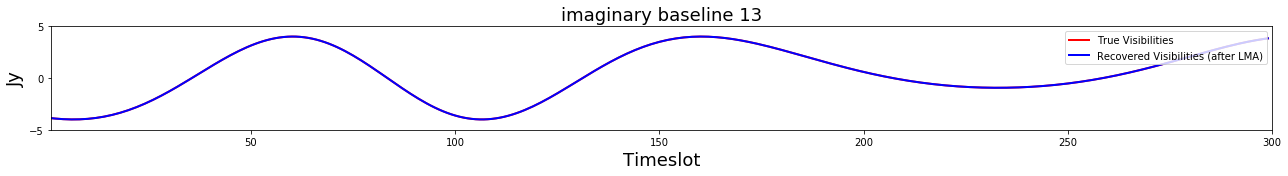

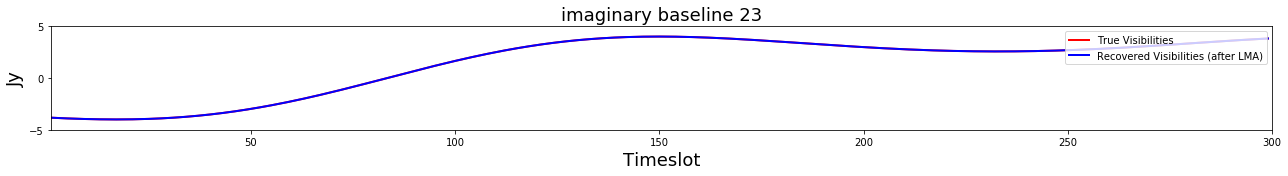

In [23]:
plotVis(m=pf.modfunc(solved_x_near, ut, vt), legend_x= ["True Visibilities","Recovered Visibilities (after LMA)"])

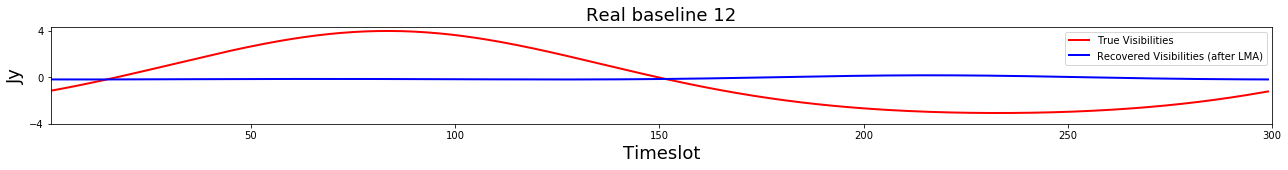

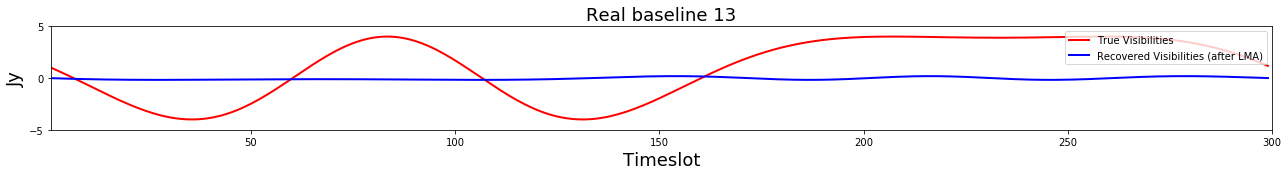

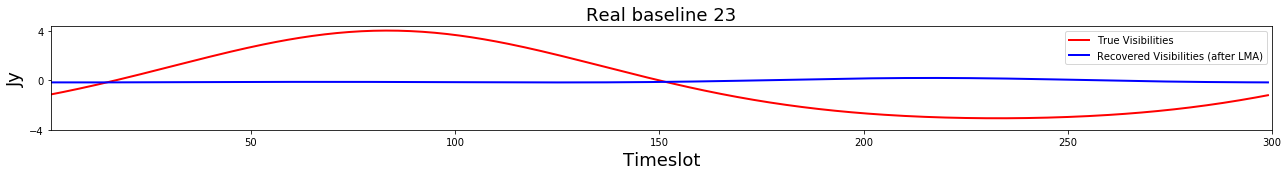

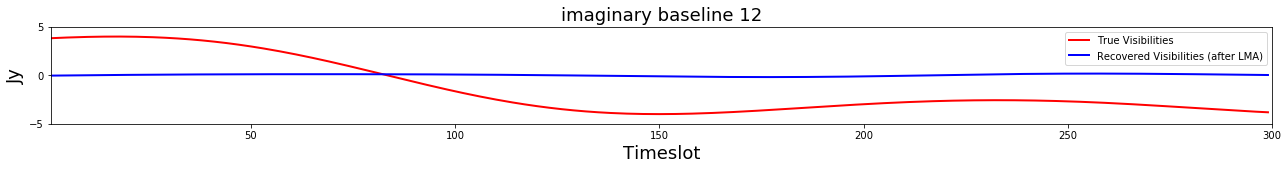

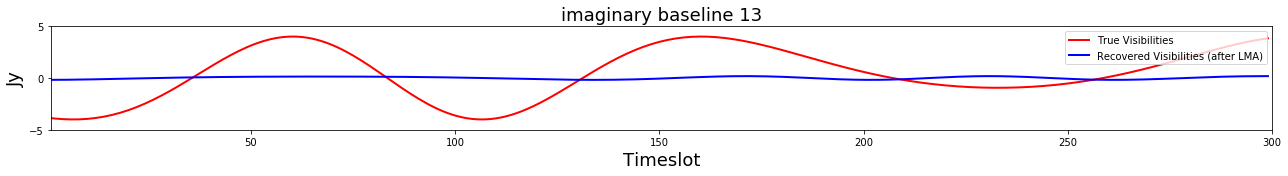

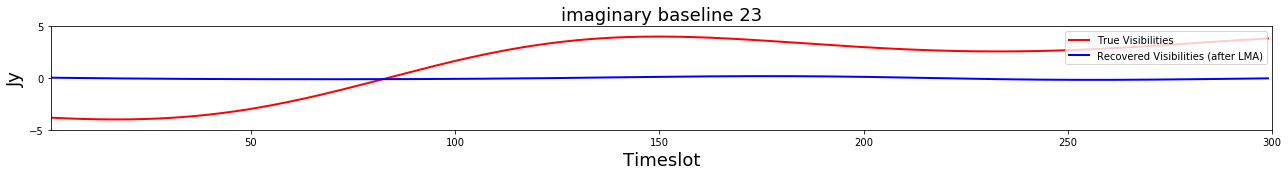

In [24]:
plotVis(m=pf.modfunc(solved_x_far, ut, vt), legend_x= ["True Visibilities","Recovered Visibilities (after LMA)"])

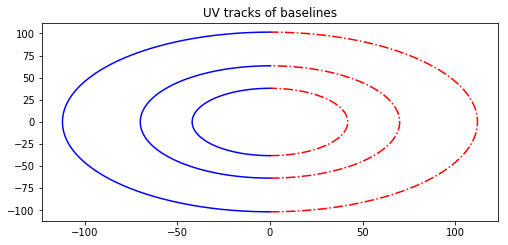

In [27]:
plt.subplot(221)
for k in range(len(ut)):
    for i in range(k,len(ut)):
        plt.plot(ut[k][i],vt[k][i],"r-.", ut[i][k],vt[i][k],"b-")
        
plt.title("UV tracks of baselines")
plt.show()

Shape of residual vec:  (1800,)
Shape of residual vec:  (1800,)
Shape of residual vec:  (1800,)
Shape of residual vec:  (1800,)
Shape of residual vec:  (1800,)
Shape of residual vec:  (1800,)


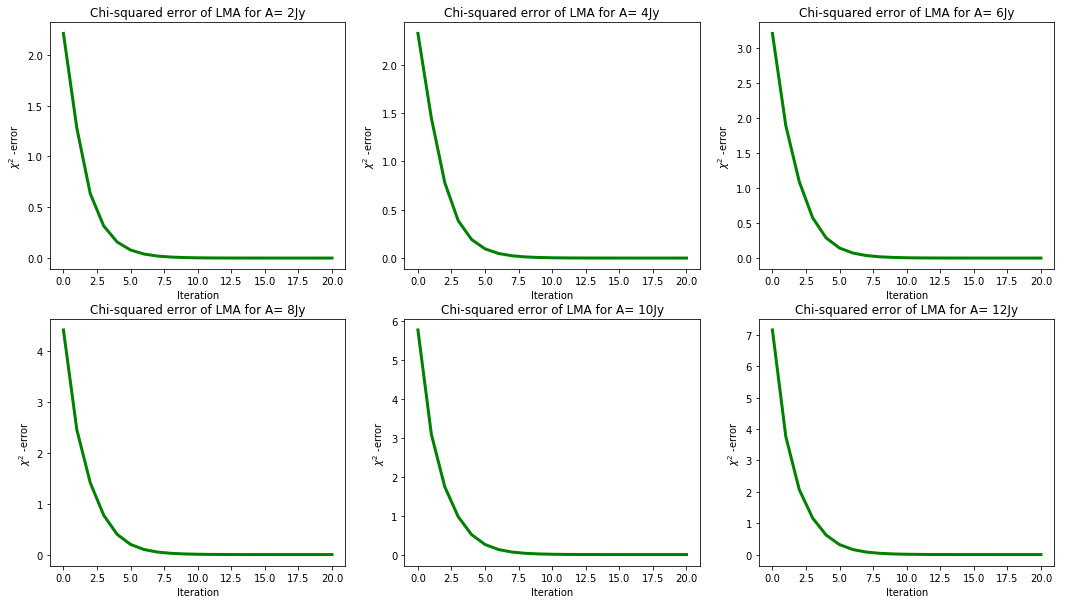

In [31]:
plt.rcParams['figure.figsize'] = (18, 10)
f, axarr = plt.subplots(2, 3)
plt.figure()
subs = [axarr[0,0],axarr[0,1],axarr[0,2],axarr[1,0],axarr[1,1],axarr[1,2]]
for i in range(1,7):
    x_mod_A= np.radians([[0.44,0.55,i*2]])
    solved_x_A,cplot_A,spath_A = levenberg_marquardt(d,ut,vt,x_mod_A,pf.modfunc_res,pf.modfunc_jac)
    subs[i-1].plot(cplot_A,'g',linewidth= 3.0)
    subs[i-1].set_xlabel("Iteration")
    subs[i-1].set_ylabel(r'$\chi^2$'+" -error")
    subs[i-1].set_title("Chi-squared error of LMA for A= {}Jy".format(i*2))
plt.show()